Goal: Use data from [phoible](https://phoible.org/) to learn a useful embedding from phonological feature space to a vector space in which distances between allophones tend to be small. Go to the [phoible project github](https://github.com/phoible/dev/tree/master/data) and grab phoible.csv for this exploration.

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn

class EmbedPhones(nn.Module):

    def __init__(self, num_features):
        super(EmbedPhones, self).__init__()
        
        self.res = nn.Linear(num_features,num_features,bias=False)
#         identity=torch.from_numpy(np.identity(num_features,dtype=np.dtype('float32')))
        with torch.no_grad():
            self.res.weight.normal_(0,0.02)
#             self.embed.weight += identity
        
    def forward(self, x):
        
        return x+self.res(x) # res represents the difference between the embedding map and the identity map


In [3]:
import os,sys
def add_path_to_local_module(module_name):
    module_path = os.path.abspath(os.path.join(module_name))
    if module_path not in sys.path:
        sys.path.append(module_path)
add_path_to_local_module("epitran")
add_path_to_local_module("panphon")

import panphon.featuretable
ft = panphon.featuretable.FeatureTable()

In [4]:
class PanphonNoLikey(Exception):
    pass

class NoAvailableData(Exception):
    pass

def to_panphon_fts(ipa_symbols):
    """ Convert a string of ipa symbols to a numpy matrix whose rows are features.
        Do not include duplicates when panphon identifies symbols in terms of features. """
    if ipa_symbols == "NA" :  raise NoAvailableData("The string you gave indicates that there's no allophone data")
    fts = ft.word_to_vector_list(ipa_symbols,numeric=True)
    if not fts : raise PanphonNoLikey("Panphon does not recognize this IPA symbol")
    fts = np.array(fts) 
    fts = np.unique(fts,axis=0) # panphon will identify some things; this gets rid of duplicates
    fts = fts.astype(np.dtype('float32'))
    return torch.from_numpy(fts)

feats = to_panphon_fts('ɛ æ')
num_features = len(feats[0])
print(num_features," features for 'ɛ æ':\n",feats)
emb = EmbedPhones(num_features)
emb(feats)

22  features for 'ɛ æ':
 tensor([[ 1.,  1., -1.,  1., -1., -1., -1.,  0.,  1., -1., -1.,  0., -1.,  0.,
         -1., -1., -1., -1., -1., -1., -1., -1.],
        [ 1.,  1., -1.,  1., -1., -1., -1.,  0.,  1., -1., -1.,  0., -1.,  0.,
         -1., -1.,  1., -1., -1., -1.,  1., -1.]])


tensor([[ 0.9673,  0.9900, -1.1050,  1.1218, -0.9670, -0.9498, -1.0924,  0.0088,
          1.0072, -1.0245, -0.9193, -0.2126, -0.8851, -0.0915, -1.1130, -0.8540,
         -0.9901, -1.0156, -1.0737, -1.0103, -1.0275, -0.8322],
        [ 0.9726,  0.9893, -1.0308,  1.1549, -0.9203, -0.9097, -1.0870, -0.0045,
          0.9938, -1.0599, -0.9625, -0.2255, -0.9510, -0.1066, -1.0706, -0.8278,
          1.0649, -0.9972, -1.0063, -0.9814,  0.9401, -0.8264]],
       grad_fn=<AddBackward0>)

In [5]:
import csv

def allophone_data_by_language(num_lists=np.inf):
    f = open('phoible.csv')
    reader = csv.reader(f)
    head = next(reader)
    allophones_index = head.index('Allophones')
    langkey_index = head.index('ISO6393')
    last_langkey = "not a lang key"
    num_yielded = 0
    for i,row in enumerate(reader):
        if row[langkey_index] != last_langkey:
#             print("About to yield data for language",last_langkey)
            last_langkey = row[langkey_index]
            if i!=0 and allophone_data:
                yield allophone_data
                num_yielded += 1
            if num_yielded >= num_lists: break
            allophone_data = []
        try:
            allophone_list = to_panphon_fts(row[allophones_index])
        except PanphonNoLikey: # We will just skip the entire list of allophones in this case
            continue
        except NoAvailableData: # We will just skip the entire list of allophones in this case
            continue
        allophone_data.append(allophone_list)
    f.close()

In [6]:
ft.word_to_vector_list('˧')

[]

In [7]:
d = allophone_data_by_language(6)
allophone_data=next(d)
allophone_data=next(d)
allophone_data=next(d)
allophone_data=next(d)
allophone_data=next(d)
allophone_data=next(d)

In [8]:
def distinct_pairs(N):
    """Generate pairs of integers i<j such that 0 <= i < j < N"""
    for i in range(N):
        for j in range(i+1,N):
            yield i,j

In [9]:
print(list(distinct_pairs(4)))

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


In [10]:
def sqdist(x,y):
    """Return squared distance between two 1D torch tensors"""
    return ((x-y)**2).sum()

In [11]:
import torch.optim as optim

emb = EmbedPhones(num_features)
lr = 0.001
optimizer = optim.Adam(emb.parameters(),lr=lr,weight_decay=1.)

In [12]:
costs = []
for step_num,allophone_data in enumerate(allophone_data_by_language()):

    allophone_dists   = 0.
    nallophone_dists  = 0. 

    optimizer.zero_grad()
    
    for allophone_list in allophone_data:
        for i,j in distinct_pairs(len(allophone_list)):
            allophone_dists += sqdist(emb(allophone_list[i]),emb(allophone_list[j]))
    for i,j in distinct_pairs(len(allophone_data)):
        for x in allophone_data[i]:
            for y in allophone_data[j]:
                nallophone_dists += sqdist(emb(x),emb(y))

    cost = allophone_dists - 0.004 * nallophone_dists
    cost.backward()
    costs.append(cost.item())
    if step_num%50==0:
        print(step_num,"languages processed. Avg cost: ",np.mean(costs))
        costs = []
    optimizer.step()

0 languages processed. Avg cost:  97.15568542480469
50 languages processed. Avg cost:  82.66782123565673
100 languages processed. Avg cost:  52.23507556915283
150 languages processed. Avg cost:  -7.391268157958985
200 languages processed. Avg cost:  -156.40296104431152
250 languages processed. Avg cost:  -168.00918228149413
300 languages processed. Avg cost:  -258.89240234375
350 languages processed. Avg cost:  -244.1227998352051
400 languages processed. Avg cost:  -492.7983517456055
450 languages processed. Avg cost:  -305.5294819641113
500 languages processed. Avg cost:  -541.4068019104004
550 languages processed. Avg cost:  -405.8478207397461
600 languages processed. Avg cost:  -549.908291015625
650 languages processed. Avg cost:  -924.232177734375
700 languages processed. Avg cost:  -1054.3478887939452
750 languages processed. Avg cost:  -944.8215661621093
800 languages processed. Avg cost:  -1793.4756622314453
850 languages processed. Avg cost:  -1549.2198699951173
900 languages p

In [13]:
emb.res.weight

Parameter containing:
tensor([[ 1.0182e+00,  9.4166e-01, -1.0968e+00,  8.4549e-01, -4.9847e-01,
         -6.5636e-01, -2.3196e-01, -2.9973e-01,  8.5888e-01, -2.3640e-01,
         -4.2198e-01,  5.5916e-02, -1.0287e+00,  2.5039e-01,  2.6265e-03,
          7.0186e-02,  6.9011e-01,  6.1996e-01,  7.4508e-01,  9.1607e-02,
          6.3379e-01,  6.4222e-01],
        [ 1.0985e+00,  4.6997e-01, -9.8451e-01,  7.1055e-01, -3.9627e-01,
         -1.7702e-01, -2.9615e-01, -2.2340e-01,  7.0490e-01, -2.2850e-01,
         -3.6341e-01,  1.9348e-02, -9.3686e-01,  2.3067e-01,  1.7408e-02,
          1.0393e-01,  6.0077e-01,  5.2175e-01,  6.8409e-01,  7.9226e-02,
          6.3031e-01,  6.2870e-01],
        [-1.0943e+00, -8.4286e-01,  9.7359e-01, -7.8524e-01,  4.4673e-01,
          5.5415e-01,  2.2207e-01,  2.3174e-01, -8.3662e-01,  2.3422e-01,
          3.8584e-01, -2.8522e-02,  9.8579e-01, -2.5758e-01, -3.9224e-02,
         -8.2661e-02, -6.9468e-01, -5.9977e-01, -6.9885e-01, -8.9505e-02,
         -6.6109e-

In [14]:
def dist(x,y):
    """distance between two feature vectors (1d torch tensors) after embedding"""
    return torch.sqrt(sqdist(emb(x),emb(y))).item()

Loading Epitran with language code ind-Latn... success!
72.43220520019531 1.4635822772979736


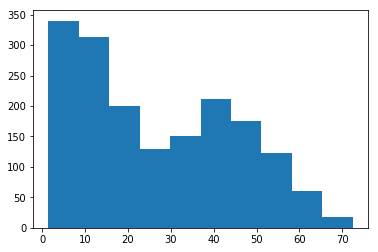

In [15]:
from wordgen import *
wg = WordgenLearned(3,"ind-Latn")

ipa_chars = wg.load_ipa_chars('eng-Latn')

dists = []
for c1 in ipa_chars:
    for c2 in ipa_chars:
        s1,s2 = to_panphon_fts(c1),to_panphon_fts(c2)
        assert(len(s1)==1)
        assert(len(s2)==1)
        s1,s2 = s1[0],s2[0]
        if c1 != c2 : dists.append(dist(s1,s2))
max_dist,min_dist = max(dists),min(dists)
print(max_dist,min_dist)
plt.hist(dists)
plt.show()

In [18]:
ipa_chars = list(wg.load_ipa_chars('eng-Latn')) # now this is an ordered list, kind of serving as an enumeration
num_chars = len(ipa_chars)
projection = [n for n in range(num_chars)] # we start with identity mapping and will gradually identify things
# think of projection as mapping from indices representing ipa_chars to equivalence classes
# the number of equivalence classes is len(set(projection))
M = 20
step_size = (max_dist-min_dist)/float((len(ipa_chars)-M)*500)
spread = step_size/2.
for r0 in np.arange(min_dist,max_dist,step_size):
    r = np.random.normal(r0,spread)
    ipa_char_index = np.random.randint(num_chars)
    s0 = to_panphon_fts(ipa_chars[ipa_char_index])
    assert(len(s0)==1)
    s0 = s0[0]
    for n in range(num_chars):
        s = to_panphon_fts(ipa_chars[n])
        assert(len(s)==1)
        s = s[0]
        if dist(s,s0)<r:
            projection[n]=projection[ipa_char_index]
    if len(set(projection))<=M: break

In [19]:
for p in set(projection):
    print([ipa_chars[n] for n in range(num_chars) if projection[n]==p])

['j']
['ɑ', 'o', 'a']
['l']
['ɾ']
['n', 'ʒ', 'z', 'ð']
['v', 'ɡ', 'm']
['t͡ʃ', 't']
['ɛ', 'ɪ']
['p']
['h', 'ʔ']
['n̩']
['e', 'i', 'ɹ̩', 'ə']
['ŋ']
['w']
['ʊ', 'æ', 'ɔ', 'ʌ']
['ɹ']
['m̩']
['u']
['d͡ʒ', 'd', 's', 'ʃ', 'θ']
['f', 'k', 'b']


Next: Make data loading stochastic, train for multiple epochs